In [1]:
# NRC Emotion Lexicon

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from afinn import Afinn
from nltk.sentiment.vader import SentimentIntensityAnalyzer

topic_result_path = '../output/topic_result_2023-05-17-15-36-44_5iter.txt'
NRC_lexicon_path = '../analysis/data/NRC-Emotion-Lexicon-v0.92-In105Languages-Nov2017Translations.xlsx'
bing_etal_lexicon_path = '../analysis/data/opinion-lexicon-English'

timestamp = '2023-05-17-15-36-44'
save_NRC_result_path = f'../analysis/result/{timestamp}_NRC_sentiment_result.xlsx'
save_AFINN_result_path = f'../analysis/result/{timestamp}_AFINN_sentiment_result.xlsx'
save_Vader_result_path = f'../analysis/result/{timestamp}_Vader_sentiment_result.xlsx'
save_Bing_etal_result_path = f'../analysis/result/{timestamp}_Bing_etal_sentiment_result.xlsx'
save_one_excel_path = f'../analysis/result/{timestamp}_all_sentiment_result.xlsx'

save_NRC_vis_scatter_result_path = f'../analysis/vis/{timestamp}_NRC_vis_scatter_result.png'
save_NRC_vis_line_result_path = f'../analysis/vis/{timestamp}_NRC_vis_line_result.png'
save_AFINN_vis_result_path = f'../analysis/vis/{timestamp}_AFINN_vis_result.png'
save_Vader_vis_result_path = f'../analysis/vis/{timestamp}_Vader_vis_result.png'
save_Bing_etal_vis_result_path = f'../analysis/vis/{timestamp}_Bing_etal_vis_result.png'
save_ratio_compete_vis_result_path = f'../analysis/vis/{timestamp}_ratio_compete_vis_result.png'


def get_tweets_by_topic(topic_result_path):
    print("saving tweets by topic to csv...")
    tweets_by_topic_df = pd.DataFrame()
    
    lines_count = len(open(topic_result_path, "r").readlines())
    reader = open(topic_result_path, "r")
    
    topic_list = []
    tweet_list = []
    i = 0
    for line in reader.readlines():
        if i % 10000 == 0:
            print(f"finished {i}/{lines_count}")
        
        split_line = line.split("(")
        doc = split_line[0]
        topic_id = int(split_line[1].split(" ")[1].split(')')[0])
        topic_list.append(topic_id)
        tweet_list.append(doc)
        i += 1
    
    tweets_by_topic_df = pd.DataFrame(list(zip(topic_list, tweet_list)), columns=['topic', 'tweet'])

    # sort dataframe by 'topic'
    df_mapping = pd.DataFrame({
        'size': [i for i in range(20)],
    })
    sort_mapping = df_mapping.reset_index().set_index('size')

    tweets_by_topic_df['topic_num'] = tweets_by_topic_df['topic'].map(sort_mapping['index'])

    tweets_by_topic_df = tweets_by_topic_df.sort_values('topic_num').drop('topic_num', axis=1)
    print(tweets_by_topic_df)

    # tweets_by_topic_df.to_csv(save_tweets_by_topic_path, sep=',', index=False,header=True)
    
    return tweets_by_topic_df
        


In [2]:
tweets_by_topic_df = get_tweets_by_topic(topic_result_path)

# NRCanalyzer = NRCLexiconAnalyzer(20, NRC_lexicon_path)
# NRCanalyzer.run(tweets_by_topic_df, visualize=True)

saving tweets by topic to csv...
finished 0/183806
finished 10000/183806
finished 20000/183806
finished 30000/183806
finished 40000/183806
finished 50000/183806
finished 60000/183806
finished 70000/183806
finished 80000/183806
finished 90000/183806
finished 100000/183806
finished 110000/183806
finished 120000/183806
finished 130000/183806
finished 140000/183806
finished 150000/183806
finished 160000/183806
finished 170000/183806
finished 180000/183806
        topic                                              tweet
133600      0  sam altman ceo openai said elimin larg number ...
153203      0  poor daddi yonder red thumb drive call danger ...
32847       0                                      threat well  
171782      0                                   take devcommun  
171781      0                                             take  
...       ...                                                ...
147477     19  game game playtoearn function core ecosystem p...
82600      19  interview

In [3]:
class NRCLexiconAnalyzer():
    def __init__(self, num_topics, NRC_lexicon_path):
        print("read NRC excel...")
        NRC = pd.read_excel(NRC_lexicon_path)
        self.emotions = ['Positive', 'Negative', 'Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
        self.NRC_en = NRC[['English (en)', *self.emotions]]
        self.emotions_words_dict = self.construct_emotions_words_dict()
        self.num_topics = num_topics
        
    def construct_emotions_words_dict(self):
        print("constructing emotions words dict...")
        tmp_list = [[] for e in self.emotions]
        emotions_words_dict = dict(zip(self.emotions, tmp_list))
        for _, row in self.NRC_en.iterrows():
            for emo in self.emotions:
                if row[emo] == 1:
                    emotions_words_dict[emo].append(row['English (en)'])
        
        return emotions_words_dict
    
    def run(self, tweets_by_topic_df, save_path="", visualize=False):
        print("NRC Lexicon Analyzer Running...")
        
        self.emotion_analysis_ret_per_topic = pd.DataFrame(np.zeros((self.num_topics, len(self.emotions) + 2)), columns=['Topic', *self.emotions, 'Ratio'])
        self.emotion_analysis_ret_per_topic['Topic'] = list(range(self.num_topics))
        # print(emotion_analysis_ret_per_topic)
        
        i = 0
        for index, row in tweets_by_topic_df.iterrows():
            if i % 10000 == 0:
                # print(self.emotion_analysis_ret_per_topic.head())
                print(f"finished {i}/{tweets_by_topic_df.shape[0]}")
            i += 1
            
            topic_id = row['topic']
            words = row['tweet'].split(" ")
            for word in words:
                for (key, value) in self.emotions_words_dict.items():
                        if word in value:
                            self.emotion_analysis_ret_per_topic.loc[topic_id, key] += 1
        
        self.emotion_analysis_ret_per_topic['Ratio'] = self.emotion_analysis_ret_per_topic['Positive'] / \
                        (self.emotion_analysis_ret_per_topic['Positive'] + self.emotion_analysis_ret_per_topic['Negative'])
                
        if save_path != "":
            self.save(save_path)

        if visualize:
            self.visualize()
            
        return self.emotion_analysis_ret_per_topic

    def save(self, save_path):
        self.emotion_analysis_ret_per_topic.to_excel(save_path, index=False, header=True)
    
    def visualize(self):
        self.visualize_scatter()
        self.visualize_line()
        
    def visualize_scatter(self):
        # draw ratio
        sns.set(rc={'figure.figsize':(4,7)}, font_scale=1.3)
        sns.scatterplot(x='Ratio', 
                        y=[f'Topic {i}' for i in range(self.num_topics)], 
                        data=self.emotion_analysis_ret_per_topic, 
                        s = 170, color="#55D4D8")
        plt.xlabel('Positive Ratio', fontsize=14)
        plt.title("NRC Lexicon")
        plt.savefig(save_NRC_vis_scatter_result_path, bbox_inches='tight', dpi=300, quality=95)
        plt.show()
        
    def visualize_line(self):
        # draw emotioms
        plt.subplots(figsize=(12, 10))

        # color={}
        for i in range(len(self.emotions)):
            # draw point
            sns.scatterplot(x=self.emotions[i], 
                            y=[f'Topic {i}' for i in range(self.num_topics)], 
                            data=self.emotion_analysis_ret_per_topic, 
                            s = 170, label=self.emotions[i])
            plt.plot(self.emotion_analysis_ret_per_topic[self.emotions[i]], [f'Topic {i}' for i in range(self.num_topics)], '-')
        plt.title("NRC Lexicon")
        plt.savefig(save_NRC_vis_line_result_path, dpi=300, quality=95)
        plt.show()

In [4]:
class AFINNLexiconAnalyzer():
    def __init__(self, num_topics):
        self.afinn = Afinn()
        self.num_topics = num_topics
        
    def run(self, tweets_by_topic_df, save_path="", visualize=False):
        print("AFINN Lexicon Analyzer Running...")
        
        scores = np.zeros(self.num_topics)
        
        i = 0
        for index, row in tweets_by_topic_df.iterrows():
            if i % 10000 == 0:
                # print(scores)
                print(f"finished {i}/{tweets_by_topic_df.shape[0]}")
            i += 1
            
            topic_id = row['topic']
            score = self.afinn.score(row['tweet'])
            scores[topic_id] += score
        
        self.emotion_analysis_ret_per_topic = pd.DataFrame({'Topic': np.arange(self.num_topics), 'Score': scores})
        
        if save_path != "":
            self.save(save_path)

        if visualize:
            self.visualize()
            
        return self.emotion_analysis_ret_per_topic

    def save(self, save_path):
        self.emotion_analysis_ret_per_topic.to_excel(save_path, index=False, header=True)
    
    def visualize(self):
        sns.set(rc={'figure.figsize':(4,7)}, font_scale=1.3)
        ax = sns.scatterplot(x='Score', 
                             y=[f'Topic {i}' for i in range(self.num_topics)], 
                             data=self.emotion_analysis_ret_per_topic, 
                             s = 170, color="#ADA0FF")
        plt.xlabel('AFINN Score', fontsize=14)
        plt.title("AFINN Lexicon")
        plt.savefig(save_AFINN_vis_result_path, bbox_inches='tight', dpi=300, quality=95)
        plt.show()

In [5]:
# AFINNanalyzer = AFINNLexiconAnalyzer(20)
# AFINNanalyzer.run(tweets_by_topic_df, save_path=save_AFINN_result_path, visualize=True)

In [6]:
class VaderLexiconAnalyzer():
    def __init__(self, num_topics):
        self.afinn = Afinn()
        self.num_topics = num_topics
        
    def nltkSentiment(self, sentence):
        sid = SentimentIntensityAnalyzer()
        senti = sid.polarity_scores(sentence)  
        return senti['neg'], senti['pos']
        
    def run(self, tweets_by_topic_df, save_path="", visualize=False):
        print("Vader Lexicon Analyzer Running...")
        
        total_neg = np.zeros(self.num_topics)
        total_pos = np.zeros(self.num_topics)

        i = 0
        for index, row in tweets_by_topic_df.iterrows():
            if i % 10000 == 0:
                print(f"finished {i}/{tweets_by_topic_df.shape[0]}")
            i += 1
            
            topic_id = row['topic']
            tweet = row['tweet']
            
            neg, pos = self.nltkSentiment(tweet)
            if neg > pos:
                total_neg[topic_id] += 1
            else:
                total_pos[topic_id] += 1    

        # print(f"total_neg: {total_neg} \ntotal_pos: {total_pos}")

        ratios = total_pos / (total_pos + total_neg)
        # print(f"positive ratio: {ratio}")

        self.emotion_analysis_ret_per_topic = pd.DataFrame({'Topic': np.arange(self.num_topics), 'Positive': total_pos, 'Negative': total_neg, 'Ratio': ratios})
        
        if save_path != "":
            self.save(save_path)

        if visualize:
            self.visualize()
            
        return self.emotion_analysis_ret_per_topic

    def save(self, save_path):
        self.emotion_analysis_ret_per_topic.to_excel(save_path, index=False, header=True)
    
    def visualize(self):
        # draw ratio
        sns.set(rc={'figure.figsize':(4,7)}, font_scale=1.3)
        sns.scatterplot(x='Ratio', 
                        y=[f'Topic {i}' for i in range(self.num_topics)], 
                        data=self.emotion_analysis_ret_per_topic, 
                        s = 170, color="#55D4D8")
        plt.xlabel('Positive Ratio', fontsize=14)
        plt.title("Vader Lexicon")
        plt.savefig(save_Vader_vis_result_path, bbox_inches='tight', dpi=300, quality=95)
        plt.show()

In [7]:
# Vaderanalyzer = VaderLexiconAnalyzer(20)
# Vaderanalyzer.run(tweets_by_topic_df, save_path=save_Vader_result_path, visualize=True)

In [8]:
class BingetalLexiconAnalyzer():
    def __init__(self, num_topics, lexicon_path):
        self.afinn = Afinn()
        self.num_topics = num_topics
        self.lexicon_path = lexicon_path
        
        self.setupLexicon()
        
    def setupLexicon(self):
        pos_path = self.lexicon_path + "/positive-words.txt"
        neg_path = self.lexicon_path + "/negative-words.txt"
        
        self.pos_lexicon = []
        self.neg_lexicon = []
        
        pos_reader = open(pos_path, 'r')
        neg_reader = open(neg_path, 'r')
        
        for line in pos_reader:
            line = line.strip('\n')
            if len(line) == 0:
                continue
            if not (line[0] >= 'a' and line[0] <= 'z'):
                continue
            
            self.pos_lexicon.append(line)
        
        for line in neg_reader:
            line = line.strip('\n')
            if len(line) == 0:
                continue
            if not (line[0] >= 'a' and line[0] <= 'z'):
                continue
            
            self.neg_lexicon.append(line)
    
    def run(self, tweets_by_topic_df, save_path="", visualize=False):
        print("Bing et al Lexicon Analyzer Running...")
        
        total_neg = np.zeros(self.num_topics)
        total_pos = np.zeros(self.num_topics)

        i = 0
        for index, row in tweets_by_topic_df.iterrows():
            if i % 10000 == 0:
                print(f"finished {i}/{tweets_by_topic_df.shape[0]}")
            i += 1
            
            topic_id = row['topic']
            words = row['tweet'].split(" ")
            for word in words:
                if word in self.pos_lexicon:
                    total_pos[topic_id] += 1

                if word in self.neg_lexicon:
                    total_neg[topic_id] += 1
            
        # print(f"total_neg: {total_neg} \ntotal_pos: {total_pos}")

        ratios = total_pos / (total_pos + total_neg)
        # print(f"positive ratio: {ratio}")

        self.emotion_analysis_ret_per_topic = pd.DataFrame({'Topic': np.arange(self.num_topics), 'Positive': total_pos, 'Negative': total_neg, 'Ratio': ratios})
        
        if save_path != "":
            self.save(save_path)

        if visualize:
            self.visualize()
            
        return self.emotion_analysis_ret_per_topic

    def save(self, save_path):
        self.emotion_analysis_ret_per_topic.to_excel(save_path, index=False, header=True)
    
    def visualize(self):
        # draw ratio
        sns.set(rc={'figure.figsize':(4,7)}, font_scale=1.3)
        sns.scatterplot(x='Ratio', 
                        y=[f'Topic {i}' for i in range(self.num_topics)], 
                        data=self.emotion_analysis_ret_per_topic, 
                        s = 170, color="#55D4D8")
        plt.xlabel('Positive Ratio', fontsize=14)
        plt.title("Bing et al Lexicon")
        plt.savefig(save_Bing_etal_vis_result_path, bbox_inches='tight', dpi=300, quality=95)
        plt.show()

In [9]:
# Binganalyzer = BingetalLexiconAnalyzer(20, bing_etal_lexicon_path)
# Binganalyzer.run(tweets_by_topic_df, save_path=save_Bing_etal_result_path, visualize=True)

In [10]:
def save_to_one_excel(save_excel_path, df_list, sheet_name_list):
    # 方法1，推荐方法
    with pd.ExcelWriter(save_excel_path) as writer:
        for df, sheet_name in zip(df_list, sheet_name_list):
            df.to_excel(writer, sheet_name=sheet_name, index=False)

def vis_ratio_compete(save_ratio_compete_vis_result_path, lexicon_list, lexicon_names):
    sns.set(rc={'figure.figsize':(5,7)}, font_scale=1.3)
    plt.title
    for (lexicon, name) in zip(lexicon_list, lexicon_names):
        sns.scatterplot(x='Ratio', 
                        y=[f'Topic {i}' for i in range(lexicon.num_topics)], 
                        data=lexicon.emotion_analysis_ret_per_topic, 
                        s = 170, label=name)
    plt.xlabel('Positive Ratio', fontsize=14)
    plt.savefig(save_ratio_compete_vis_result_path, bbox_inches='tight', dpi=300, quality=95)
    plt.show()

read NRC excel...
constructing emotions words dict...
NRC Lexicon Analyzer Running...
finished 0/183806
finished 10000/183806
finished 20000/183806
finished 30000/183806
finished 40000/183806
finished 50000/183806
finished 60000/183806
finished 70000/183806
finished 80000/183806
finished 90000/183806
finished 100000/183806
finished 110000/183806
finished 120000/183806
finished 130000/183806
finished 140000/183806
finished 150000/183806
finished 160000/183806
finished 170000/183806
finished 180000/183806


/home/dx/miniconda3/envs/btm/lib/python3.6/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


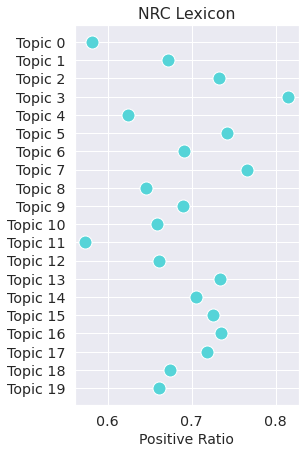

/home/dx/miniconda3/envs/btm/lib/python3.6/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


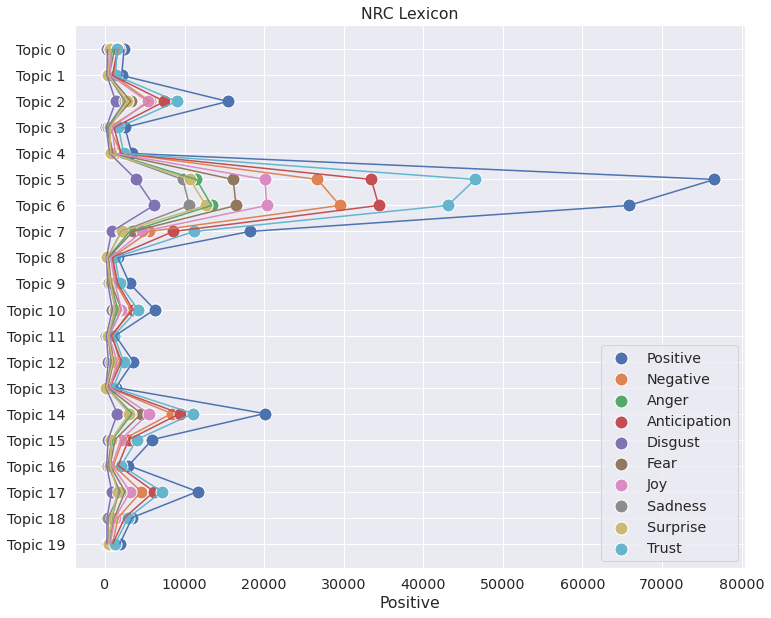

AFINN Lexicon Analyzer Running...
finished 0/183806
finished 10000/183806
finished 20000/183806
finished 30000/183806
finished 40000/183806
finished 50000/183806
finished 60000/183806
finished 70000/183806
finished 80000/183806
finished 90000/183806
finished 100000/183806
finished 110000/183806
finished 120000/183806
finished 130000/183806
finished 140000/183806
finished 150000/183806
finished 160000/183806
finished 170000/183806
finished 180000/183806


/home/dx/miniconda3/envs/btm/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later


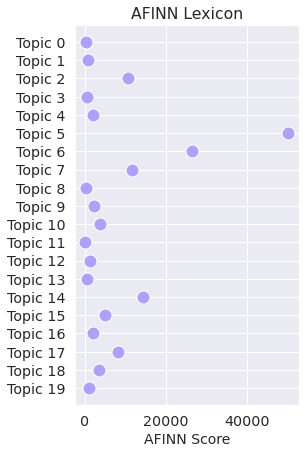

Vader Lexicon Analyzer Running...
finished 0/183806
finished 10000/183806
finished 20000/183806


In [11]:
NRCanalyzer = NRCLexiconAnalyzer(20, NRC_lexicon_path)
NRCanalyzer.run(tweets_by_topic_df, visualize=True)
# NRCanalyzer.run(tweets_by_topic_df, save_path=save_NRC_result_path, visualize=True)

AFINNanalyzer = AFINNLexiconAnalyzer(20)
AFINNanalyzer.run(tweets_by_topic_df, visualize=True)
# AFINNanalyzer.run(tweets_by_topic_df, save_path=save_AFINN_result_path, visualize=True)

Vaderanalyzer = VaderLexiconAnalyzer(20)
Vaderanalyzer.run(tweets_by_topic_df, visualize=True)
# Vaderanalyzer.run(tweets_by_topic_df, save_path=save_Vader_result_path, visualize=True)

Binganalyzer = BingetalLexiconAnalyzer(20, bing_etal_lexicon_path)
Binganalyzer.run(tweets_by_topic_df, visualize=True)
# Binganalyzer.run(tweets_by_topic_df, save_path=save_Bing_etal_result_path, visualize=True)

In [12]:
save_to_one_excel(save_one_excel_path, 
                      [NRCanalyzer.emotion_analysis_ret_per_topic, AFINNanalyzer.emotion_analysis_ret_per_topic, 
                        Vaderanalyzer.emotion_analysis_ret_per_topic, Binganalyzer.emotion_analysis_ret_per_topic],
                      ['NRC', 'AFINN', 'Vader', 'Bingetal'])

,topic,tweet
133600,0,sam altman ceo openai said elimin larg number ...
153203,0,poor daddi yonder red thumb drive call danger ...
32847,0,threat well
171782,0,take devcommun
171781,0,take


In [ ]:
vis_ratio_compete(save_ratio_compete_vis_result_path, [NRCanalyzer, Vaderanalyzer, Binganalyzer], ['NRC', 'Vader', 'Bing et al'])